# ADAPT-VQE

ADAPT-VQE was introduced by [Grimsley et al](https://www.nature.com/articles/s41467-019-10988-2) as a solution to the often impracticably deep, and not necessarily accurate, static VQE circuits. In ansatze like UCCSD, one easily reaches the order of thousands of gates, even for modestly sized molecules. In UCCSD and its generalized UCCGSD, the number of fermionic excitations in the ansatz scales like $\mathcal{O}(N^2M^2)$, and $\mathcal{O}(N^4)$ respectively. Here $N$ refers to the number of spin-orbitals in the problem basis, and $M$ the number of electrons.

In ADAPT-VQE, an ansatz which approximates not UCCSD/UCCGSD, but in fact FCI, is built iteratively. Over a series of cycles, the ansatz circuit is grown to achieve an approximation to FCI with a minimal number of circuit elements. In this way, ADAPT-VQE is a meta-VQE. At each step, a new ansatz is defined, and its parameters optimized according to conventional VQE. As the cycles proceed, the ansatz grows in both complexity and expressibility. This algorithm comes at the expense of a significant increase in measurement overhead. In order to identify the best operator to append to the present ansatz circuit, a large number of measurements are performed to rank the available operators in order of their ability to further reduce the ansatz state energy.

In this notebook, we'll explore the implementation of this algorithm, by taking advantage of the tools available through the qSDK. 

## Implementation Strategy

ADAPT-VQE relies on three principal steps.

1. Construct generator pool $\{P_i\}$, a set of available operators from which we will iteratively construct the ansatz.
2. Rank operators by evaluating the gradient for each operator in the pool $\frac{\partial E^{(k)}}{\partial \theta_i} = \langle \psi_k|[H,P_i]|\psi_k\rangle$. Exit if the largest partial derivative is less than some cutoff.
3. Append $U_k = \mathrm{exp}[i\theta_k P_k]$(index) to the ansatz $U=\prod_k U_k(\theta_k)$, and optimize $\langle H\rangle$ using VQE.
4. Return to step 2.

There are two obvious avenues along which one can be creative in the implementation of ADAPT-VQE--these are the selection of the operator pool $\{P_i\}$, and the ranking strategy. Above, we have specified that we are using the gradient to perform this ranking procedure. To my knowledge this is the only method which has been used previously, and we will continue to do so here. Regarding the choice of operator pool, the original authors used the elements of the UCCGSD, i.e. the single, double fermionic excitations. Subsequent work has focused on qubit-native operators, and we'll follow this strategy as well. Although the UCCGSD allows for high accuracy with a small number of cycles (and consequently very few variational parameters), the circuit remains very deep, as each excitation consists of many multi-qubit Pauli rotations. 

## Hamiltonian-Inspired Qubit-ADAPT
We are going to use the Hamiltonian to establish a set of pool generators to use in our implementation of ADAPT-VQE. For each term in the Hamiltonian which acts on a distinct combination of qubits, we'll add a pool operator which is guaranteed to have a non-zero commutator with respect to H, and therefore a finite gradient. This will give us a fairly compact set of operators in the pool, all of which are likely to be useful in our ansatz construction. To do this, we will scan through all terms in the qubit Hamiltonian. For each, we will identify the Pauli operators associated with electronic excitation (X and Y gates). We discard Z gates from the Pauli string. If the number of Y gates in a string is even, we can use this to construct an excitation pool element that preserves T-symmetry, by flipping one of the other X gates to a Y, or a Y to an X. Below, we'll flip the first X or Y to its partner.

In [30]:
import numpy as np

from qsdk.toolboxes.operators.operators import QubitOperator

pauli_lookup = {'Z':1, 'X':2, 'Y':3}
pauli_reverse_lookup = ['I', 'Z', 'X', 'Y']

def get_pool(qubit_hamiltonian, n_qubits):
    """Use Hamiltonian to identify non-commuting Pauli strings to use as operator pool.
    We identify terms with even number of Y-operators, in order to define excitations 
    which preserve T-reversal symmetry. We remove all Z operators, and we flip the first
    X or Y to its partner (i.e. X <> Y).
    Args:
        qubit_hamiltonian (QubitOperator): input Hamiltonian
        n_qubits (int): number of qubits for Hamiltonian
    
    Returns:
        pool_generators (list of QubitOperator): list of generators
    """

    pool_generators, pool_tuples = list(), list()
    indices = list()

    for term in qubit_hamiltonian.terms:
        pauli_string = np.zeros(n_qubits, dtype=int)
        
        #identify all X or Y factors
        for index, action in term:
            if pauli_lookup[action] > 1:
                pauli_string[index] = pauli_lookup[action]

        #only allow one operator acting on a given set of qubits
        action_mask = tuple(pauli_string > 1)
        if action_mask in indices:
            continue

        #only consider terms with even number of Y
        if sum(pauli_string) % 2 == 0 and sum(pauli_string) > 0:
            #identify qubit operator to change X<>Y
            flip_index = np.where(pauli_string > 1)[0][0]
            pauli_string[flip_index] += (-1)**(pauli_string[flip_index] % 2) 

            #update set of used qubit combinations
            indices.append(action_mask)
            #create QubitOperator for the new generator
            operator_tuple = tuple([(index,pauli_reverse_lookup[pauli]) for index, pauli in enumerate(pauli_string) if pauli > 0])
            #We don't use the coefficients directly, so since we need to multiply by 1.j for evaluating gradients, 
            #I'm just instantiating these with that coefficient in place
            pool_generators.append(QubitOperator(operator_tuple, 1.0j))
            pool_tuples.append(operator_tuple)
    
    return pool_generators, pool_tuples

To exemplify the generation of an operator pool, we will apply this method to a simple Hamiltonian consisting of a single fermionic excitation and its Hermitian conjugate.

In [128]:
from qsdk.toolboxes.operators import QubitOperator
qubit_hamiltonian = QubitOperator(((0, 'X'), (1, 'X'), (2, 'Y'), (3, 'Y')), -1.0) \
                  + QubitOperator(((0, 'X'), (1, 'Y'), (2, 'Y'), (3, 'X')), 1.0) \
                  + QubitOperator(((0, 'Y'), (1, 'X'), (2, 'X'), (3, 'Y')), 1.0) \
                  + QubitOperator(((0, 'Y'), (1, 'Y'), (2, 'X'), (3, 'X')), -1.0) 
pool_generators, pool_tuples = get_pool(qubit_hamiltonian, n_qubits=4)
print(f'OPERATOR POOL: {pool_tuples}')

OPERATOR POOL: [((0, 'Y'), (1, 'X'), (2, 'Y'), (3, 'Y'))]


We have used a qubit Hamiltonian where all operators act on the same qubit indices. This results in just a single generator pool element. As we traverse the `qubit_hamiltonian` in order, the generator corresponds to the first term in the Hamiltonian, with the first X operator switched to a Y operator. So from XXYY, we have YXYY. 

With the pool generators so defined, we will need to prepare an observable enabling us to get expectation values for: $\frac{\partial E^{(k)}}{\partial \theta_i} = i\langle \psi_k|[H,P_i]|\psi_k\rangle$. I'm going to use openfermion's *commutator* method to construct a set of observables associated with my generator pool.

In [14]:
from openfermion import commutator

def get_commutators(qubit_hamiltonian, pool_generators):
    gradient_operators = [commutator(qubit_hamiltonian, element) for element in pool_generators]
    return gradient_operators


We can use the same operator from above to have a look at the commutator for the single pool-element we generated.

In [130]:
gradient = get_commutators(qubit_hamiltonian, pool_generators)
print(gradient)

[(2+0j) [Z0] +
(-2+0j) [Z0 Z1 Z3] +
(2-0j) [Z1 Z2 Z3] +
(-2+0j) [Z2]]


We see that this operator can have finite expectation value for a product state -- which is essential to get the ADAPT-VQE algorithm started, when beginning with a Hartree-Fock product-state reference expressed in the computational basis. We can get a finite gradient, append to our ansatz and proceed. Let's go ahead and define a method to find the best operator to append to our circuit, in the non-trivial case where we have several pool elements to choose from.

In [131]:
def rank_pool(pool_commutators, circuit, backend, tolerance=1e-3):

    gradient = [abs(backend.get_expectation_value(element, circuit)) for element in pool_commutators]
    max_partial = max(gradient)
    print(f'LARGEST PARTIAL DERIVATIVE: {max_partial :4E}')
    return gradient.index(max_partial) if max_partial >= tolerance else -1


## Adaptive-Ansatz
Now that we have a method by which to rank our pool elements, we need to be able to update our ansatz circuit. Since I am going to be using the qSDK's `VQESolver` class as the kernel of my ADAPT-VQE calculation, I need to define my custom ansatz. For an introduction to defining your own ansatz, check out the tutorial in the qSDK [GitHub repository](https://github.com/1QB-Information-Technologies/QEMIST_qSDK/blob/main/examples/vqe_custom_ansatz.ipynb). In addition to the requisite methods to build the circuit and reference state, as well as set and update the variational parameters, we also define a method for adding a new operator to the ansatz circuit. This enables us to circumvent rebuilding our variational circuit from scratch on every cycle of ADAPT.

In building our circuit, we'll make use of the `pauliword_to_circuit` method from the qSDK to construct the necessary gate sequence associated with a multi-qubit Pauli rotation $\mathrm{exp}(i\theta \prod_j \sigma_j)$.

In [132]:
from qsdk.toolboxes.qubit_mappings.statevector_mapping import get_reference_circuit
from qsdk.toolboxes.ansatz_generator.ansatz_utils import pauliword_to_circuit
from qsdk.toolboxes.ansatz_generator.ansatz import Ansatz
from agnostic_simulator import Circuit

class AdaptAnsatz(Ansatz):

    def __init__(self, n_spinorbitals, n_electrons, operators):
        
        self.n_spinorbitals = n_spinorbitals
        self.n_electrons = n_electrons
        self.operators = operators
        
        self.n_var_params = len(self.operators)

        self.var_params = None
        self.circuit = None

    def set_var_params(self, var_params=None):
        """Set initial variational parameter values"""
        if var_params is None:
            var_params = np.random.random(self.n_var_params)
        elif var_params.size != self.n_var_params:
            raise ValueError('Invalid number of parameters.')
        self.var_params = var_params
        return var_params

    def update_var_params(self, var_params):
        """Update variational parameters (done repeatedly during VQE)"""
        for param_index in range(self.n_var_params):
            self.circuit._variational_gates[param_index].parameter = var_params[param_index]
    
    def prepare_reference_state(self):
        """Prepare a circuit generating the HF reference state."""
        return get_reference_circuit(n_spinorbitals=self.n_spinorbitals, n_electrons=self.n_electrons, mapping='JW')

    def build_circuit(self, var_params=None):
        """Construct the variational circuit to be used as our ansatz."""
        self.set_var_params(var_params)

        self.circuit = Circuit(n_qubits=self.n_spinorbitals)
        self.circuit += self.prepare_reference_state()
        adapt_circuit = Circuit()
        for op in self.operators:
            adapt_circuit += pauliword_to_circuit(op, 1.0)

        if adapt_circuit.size != 0:   
            self.circuit += adapt_circuit
        return self.circuit
    
    def add_operator(self,pauli_tuple):
        """Add a new operator to our circuit"""
        new_operator = Circuit(pauliword_to_circuit(pauli_tuple, 1.0))
        self.circuit += new_operator
        self.n_var_params += 1 

In my experience, I get the best performance with ADAPT-VQE when I use the L-BFGS-B optimization algorithm. In the qSDK's `VQESolver`, the default optimizer uses SLSQP. This is pretty easy to change in the qSDK's `VQESolver`. I just define the following method, which can be passed as an input argument to `VQESolver`.

In [134]:
from scipy.optimize import minimize

def LBFGSB_optimizer(func, var_params):
    result = minimize(func, var_params, method="L-BFGS-B", options={"disp": True, "maxiter": 100, 'gtol':1e-10})
    
    print(f"\tOptimal UCCSD energy: {result.fun}")
    print(f"\tOptimal UCCSD variational parameters: {result.x}")
    print(f"\tNumber of Function Evaluations : {result.nfev}")
    return result

## Assembling the ADAPT Workflow
With all of these tools prepared, we can proceed to define an ADAPT-VQE method. We'll continue to take advantage of the tools provided by the qSDK to minimize the overhead in prototyping this algorithm, utilizing the built-in `VQESolver` class to formulate the kernel of our workflow. We'll use the `MolecularData` class to construct our generator pool, and then wrap the `VQESolver` in a loop. For each cycle, we identify the best choice of generator, update the ansatz circuit, and run VQE again.

In [135]:
from qsdk.electronic_structure_solvers.vqe_solver import VQESolver

def do_adapt_vqe(molecule, tol=1e-3, max_cycle=10):
    """Perform ADAPT-VQE using the Hamiltonian-based qubit pool.
    The gradient is evaluated at the start of each step for all operators
    in pool, and the element with the largest gradient is appended to the
    ansatz. The continues until either the largest gradient drops below a
    threshold tolerance, or, the number of cycles exceeds the stated maximum.
    the tolerance. 
    Args:
        molecule (pyscf's gto.Mole): objective molecule to solve for
        tol (float): cutoff scale for largest gradient
        max_cycle (int): cutoff number of iterations before terminating
    
    Returns:
        energies (list of float): VQE energy at each cycle of ADAPT
        operators (list of tuple): Pauli strings for each generator in the ADAPT ansatz
        vqe (VQESolver): solver class
    """

    operators = list()
    energies = list()
    params = np.array([0.0])
    
    converged = False
    ansatz = AdaptAnsatz(n_spinorbitals=2*molecule.nbas, n_electrons=molecule.nelectron, operators=operators)
    
    vqe_options = {'molecule':molecule, 'qubit_mapping':'JW', 'ansatz':ansatz,'optimizer':LBFGSB_optimizer}
    vqe = VQESolver(vqe_options)
    vqe.build()
    
    pool_operators, pool_tuples = get_pool(vqe.qubit_hamiltonian, 2*molecule.nbas)
    commutators = get_commutators(vqe.qubit_hamiltonian, pool_operators)

    while not converged:
        if len(operators) > max_cycle:
            break
        pool_select = rank_pool(commutators, vqe.ansatz.circuit, backend=vqe.backend, tolerance=tol)

        if pool_select >-1:
            operators.append(pool_tuples[pool_select])
            vqe.ansatz.add_operator(operators[-1])
            vqe.initial_var_params = params
            optimal = vqe.simulate()
            energies.append(optimal.fun)
            params = np.concatenate([optimal.x, np.array([0])])
        else:
            converged = True

    return energies, operators, vqe

## ADAPT-VQE In Practice
For the generator pool we've considered here, the smallest non-trivial problem to consider is H$_4$, as H$_2$ has only one generator and ADAPT terminates at FCI accuracy after a single iteration. So we'll apply this here to H$_4$ as a linear chain. We begin by instantiating the molecule object from pyscf's `gto.Mole` class, and feed this into the `do_adapt_vqe` method we defined above.

In [142]:
from pyscf import gto

H4 = [('H', (0, 0, 0)), ('H', (0, 0, 1)), ('H', (0, 0, 2)), ('H', (0, 0, 3))]
mol = gto.Mole()
mol.atom = H4
mol.basis = 'sto-3g'
mol.build()

energies, operators, adapt_vqe = do_adapt_vqe(mol, tol=1e-4, max_cycle=15)

LARGEST PARTIAL DERIVATIVE: 2.745654E-01
	Optimal UCCSD energy: -2.122499869835747
	Optimal UCCSD variational parameters: [-0.34549446]
	Number of Function Evaluations : 10
LARGEST PARTIAL DERIVATIVE: 2.422185E-01
	Optimal UCCSD energy: -2.132839379197322
	Optimal UCCSD variational parameters: [-0.36933601 -0.1704421 ]
	Number of Function Evaluations : 21
LARGEST PARTIAL DERIVATIVE: 2.507048E-01
	Optimal UCCSD energy: -2.1439830966095133
	Optimal UCCSD variational parameters: [-0.39765266 -0.17750621 -0.17750635]
	Number of Function Evaluations : 32
LARGEST PARTIAL DERIVATIVE: 2.355767E-01
	Optimal UCCSD energy: -2.150427234468344
	Optimal UCCSD variational parameters: [-0.39615962 -0.18080608 -0.1848486  -0.10933224]
	Number of Function Evaluations : 35
LARGEST PARTIAL DERIVATIVE: 1.465512E-01
	Optimal UCCSD energy: -2.1543855334425612
	Optimal UCCSD variational parameters: [-0.36948384 -0.18437109 -0.18148065 -0.10194413 -0.10855794]
	Number of Function Evaluations : 48
LARGEST PARTI

After 15 cycles, we force the cycle to terminate. At this point, the largest gradient is below the level of 0.01. We can now compare the results against the predictions of FCI.

Final Error: 1.4115E-04


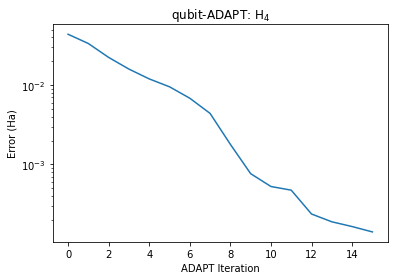

In [143]:
import matplotlib.pyplot as plt
from qsdk.toolboxes.molecular_computation.molecular_data import MolecularData
qem_mol = MolecularData(mol)
exact = qem_mol.fci_energy
errors = np.array(energies) - exact
fig,ax = plt.subplots(1,1)
ax.plot(errors)
ax.set_xlabel('ADAPT Iteration')
ax.set_ylabel('Error (Ha)')
ax.set_title('qubit-ADAPT: H$_4$')
ax.set_yscale('log')
print(f'Final Error: {errors[-1] :.4E}')

Ok so after 15 cycles, we have an error of 0.14 mHa, within chemical accuracy of FCI. How does this all compare against UCCSD-VQE?

In [144]:
vqe_uccsd = VQESolver({'molecule': mol})
vqe_uccsd.build()
vqe_uccsd.simulate()

/Users/ryanday/Documents/QComp/qSDK/QEMIST_qSDK/qsdk/toolboxes/ansatz_generator/uccsd.py:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params == "ones":
/Users/ryanday/Documents/QComp/qSDK/QEMIST_qSDK/qsdk/toolboxes/ansatz_generator/uccsd.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif var_params == "random":
/Users/ryanday/Documents/QComp/qSDK/QEMIST_qSDK/qsdk/toolboxes/ansatz_generator/uccsd.py:65: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif var_params == "MP2":
Pauli words in qubit operator have changed, rebuilding UCCSD ansatz circuit.
Pauli words in qubit operator have changed, rebuilding UCCSD ansatz circuit.
Pauli words in qubit operator have changed, rebuilding UCCSD ansatz circuit.
Pauli words in qubit opera

-2.166303877783326

In [145]:
print(f'ADAPT-VQE ERROR: {energies[-1] - exact :0.4E} Ha')
print(f'UCCSD-VQE ERROR: {vqe_uccsd.optimal_energy - exact :0.4E} Ha')

ADAPT-VQE ERROR: 1.4115E-04 Ha
UCCSD-VQE ERROR: 8.3571E-05 Ha


From the perspective of energy accuracy, the two have reached very similar results, within a factor of two. The big advantage here however, are in the resources required for this ansatz circuit:

In [146]:
print(f'ADAPT RESOURCES:\n {adapt_vqe.get_resources()}\n')
print(f'UCCSD RESOURCES:\n {vqe_uccsd.get_resources()}')

ADAPT RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 228, 'circuit_2qubit_gates': 88, 'circuit_var_gates': 16, 'vqe_variational_parameters': 16}

UCCSD RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2692, 'circuit_2qubit_gates': 1312, 'circuit_var_gates': 160, 'vqe_variational_parameters': 14}


We have managed here to reduce the total number of gates by a factor of 10, the number of 2-qubit gates by a factor of nearly 15, and variational gates by a factor of 10. 

We note that ADAPT-VQE has run with 2 more variational parameters than UCCSD-VQE. This introduces additional overhead to the classical optimizer, which must find an optimal solution within a higher-dimensional space. However, the number of variational parameters for ADAPT-VQE is directly dependent on the number of cycles over which ADAPT is run. We then have the opportunity to compromise between optimization complexity and ansatz expressivity by limiting the number of cycles, and therefore the number of variational parameters (and gate number and depth) associated with a computation. This flexibility in resource requirements is then an important advantage for the ADAPT-VQE algorithm over static ansatze.

## Conclusion

In this notebook, we've explored a simple implementation of the ADAPT-VQE algorithm, using tools available through the qSDK. We have demonstrated how we can leverage these tools to reduce the effort involved in prototyping new quantum algorithms. This allows the user to focus exclusively on the specific components relevant to their research objectives, without getting bogged down in re-building standard infrastructure from scratch. 

The ADAPT-VQE algorithm provides the flexibility to explore different choices of generator pools, and ranking criteria. Feel free to try out alternative implementations to get a better sense of what this algorithm can do.

RP Day
